In [1]:
import os
import pickle
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib.pyplot as plt
from Haldane_anis_supervise_class import *
from partial import *

In [12]:
L = 5  # number of particles must be odd
keep = [2,3,4] # keep the part that we wanna do partial trace over that
bond = 10  # reasonable amount
p = partial(L, keep, bond)

In [8]:
path = p.path()

# Load the training set and gram train partial density matrix
train_path = os.path.join(path, 'train_set_DMRG.pkl')
with open(train_path, 'rb') as f:
    train_set = pickle.load(f)

partial_density_matrix_train, _ = p.partial_density_matrix()
kernel_partial_train = p.gram_train_partial(partial_train=partial_density_matrix_train)


Computing partial density matrices started .....
Ops! Test dataset not found. Generating it .....


Generating test set: 100%|██████████| 1600/1600 [01:28<00:00, 18.11it/s]


Tracing over training set (187 items)...


Tracing train set: 100%|██████████| 187/187 [00:02<00:00, 90.77it/s]


Tracing over test set (1600 items)...


Tracing test set: 100%|██████████| 1600/1600 [00:00<00:00, 1956.55it/s]


Partial density matrices computed in 93.10 seconds.
Computing Gram matrix for training set...


Gram Partial Train: 100%|██████████| 34969/34969 [00:00<00:00, 73729.28it/s]


Gram matrix for training set computed in 0.51 seconds.


In [5]:
L = len(keep) # number of particles for test part 
bond  = 50
H = Haldan_anis(L = L, bond = bond)

In [6]:
test_set = H.generate_test_set()
d = len(test_set)  # dimension of the local Hilbert space
trace_test_set=[]
for i in range(d):
    a = test_set[i].partial_trace_to_dense_canonical(where=[0,1,2])
    trace_test_set.append(a)

Generating test set: 100%|██████████| 1600/1600 [00:18<00:00, 87.18it/s]


In [10]:
d1 = len(trace_test_set)
d2 = len(partial_density_matrix_train)
gram_matrix_test = np.zeros((d1,d2))
for i in tqdm(range(d1), desc='Gram Test Scalable'):
    for j in range(d2):
        gram_matrix_test[i,j] = (
            np.trace(trace_test_set[i] @ partial_density_matrix_train[j]).real)**2
        
file_path_kernel_test_scalable = os.path.join(path,"kernel_test_scalable.hdf5")
with h5py.File(file_path_kernel_test_scalable, "w") as f:
    f.create_dataset("gram_test_scalable", data=gram_matrix_test)

Gram Test Scalable: 100%|██████████| 1600/1600 [00:07<00:00, 225.66it/s]


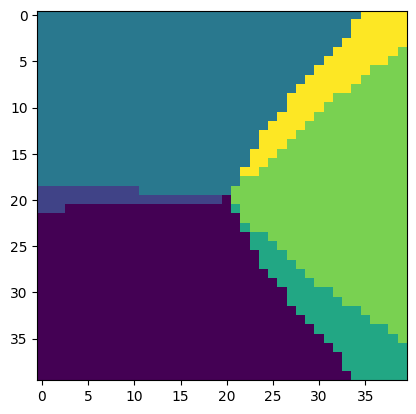

In [11]:
clf = svm.SVC(kernel='precomputed')
kernel_train = kernel_partial_train
kernel_test = gram_matrix_test
y = train_set[1]
clf.fit(kernel_train**0.1, y) 
y_pred = clf.predict(kernel_test)
plt.imshow(y_pred.reshape(40,40))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()